In [ ]:
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw
import os
from collections import Counter
import numpy as np

# Define the transform for preprocessing
transform = transforms.Compose([
    transforms.Resize((300, 300)),  # Resize images to a fixed size
    transforms.ToTensor(),  # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # Normalize
])

In [ ]:
# Load the Pascal VOC train and test datasets
voc_train = datasets.VOCDetection(root='./data', year='2012', image_set='train', download=True, transform=transform)
voc_test = datasets.VOCDetection(root='./data', year='2012', image_set='val', download=True, transform=transform)


100%|██████████| 2.00G/2.00G [01:31<00:00, 21.9MB/s]


Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


In [ ]:
# Get dataset sizes
train_size = len(voc_train)
test_size = len(voc_test)
print(f"Train Dataset Size: {train_size} images")
print(f"Test Dataset Size: {test_size} images")


Train Dataset Size: 5717 images
Test Dataset Size: 5823 images


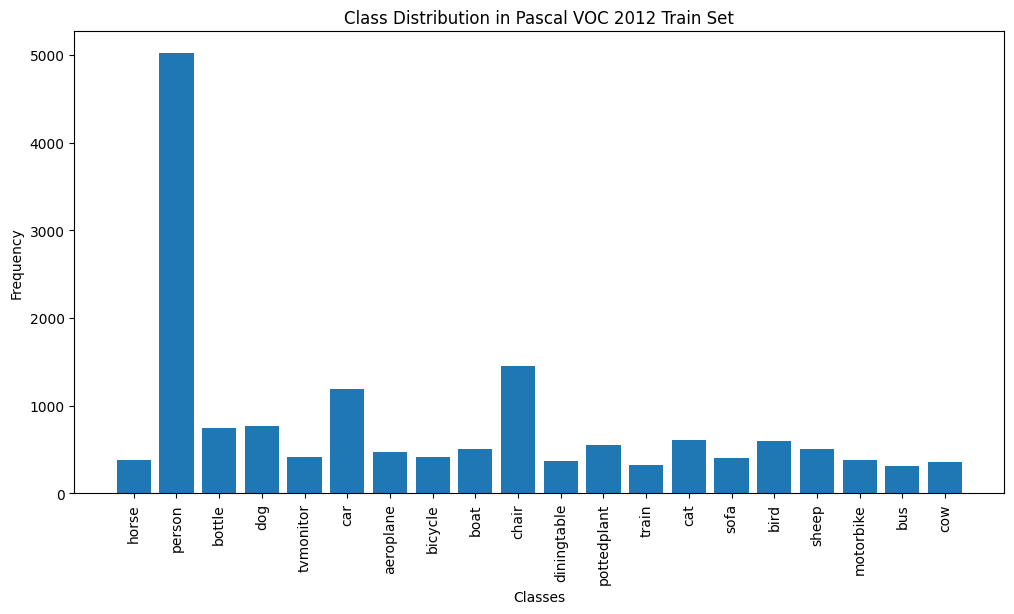

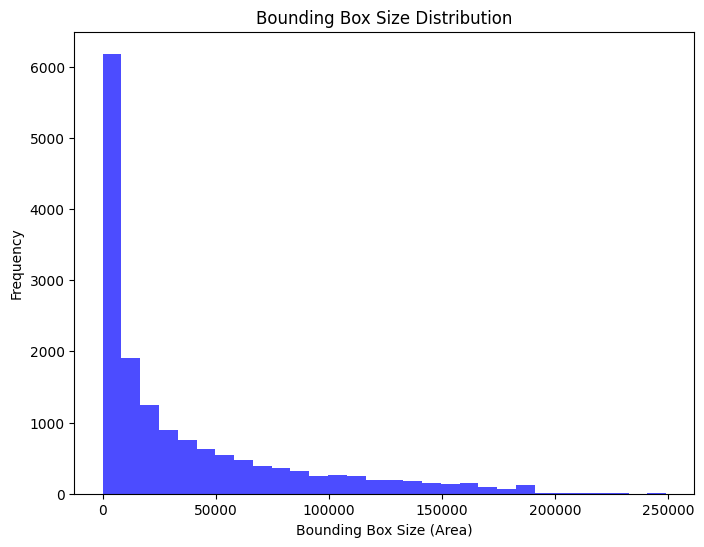

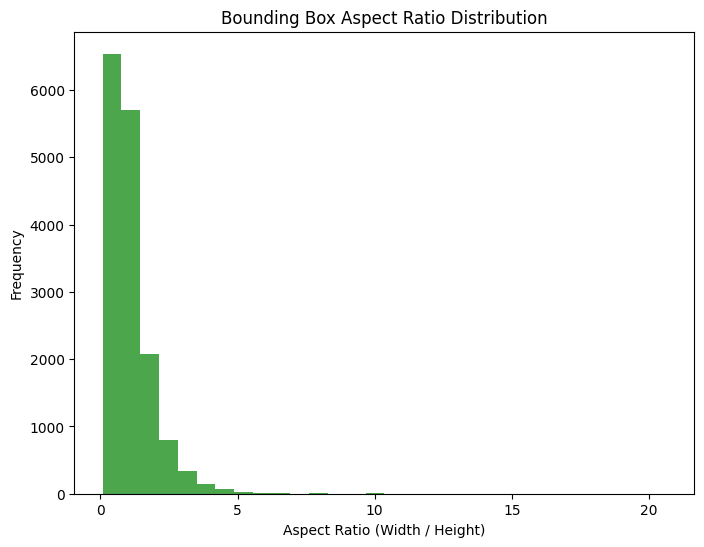

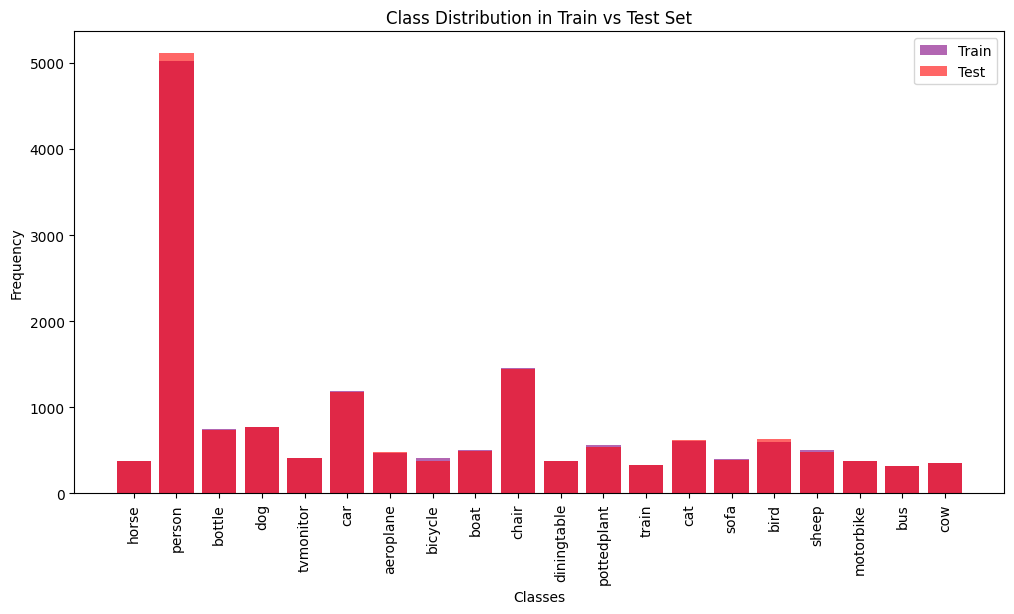

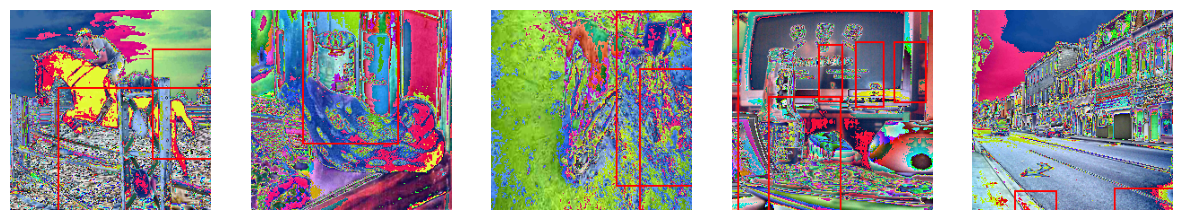

In [ ]:
# Function to parse the annotation
def extract_annotations(annotation):
    objects = annotation["annotation"]["object"]
    if not isinstance(objects, list):
        objects = [objects]

    labels = []
    bbox_sizes = []
    aspect_ratios = []

    for obj in objects:
        labels.append(obj["name"])
        bbox = obj["bndbox"]
        xmin, ymin, xmax, ymax = int(bbox["xmin"]), int(bbox["ymin"]), int(bbox["xmax"]), int(bbox["ymax"])
        width, height = xmax - xmin, ymax - ymin
        bbox_sizes.append(width * height)
        aspect_ratios.append(width / height if height != 0 else 0)

    return labels, bbox_sizes, aspect_ratios

# Analyze the dataset
class_counts = Counter()
bbox_sizes = []
aspect_ratios = []
image_dims = []

for i in range(len(voc_train)):
    image, annotation = voc_train[i]
    labels, sizes, ratios = extract_annotations(annotation)
    class_counts.update(labels)
    bbox_sizes.extend(sizes)
    aspect_ratios.extend(ratios)
    image_dims.append(image.shape[1:])  # Save image dimensions

# Plot class distribution
plt.figure(figsize=(12, 6))
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=90)
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.title("Class Distribution in Pascal VOC 2012 Train Set")
plt.show()

# Plot bounding box size distribution
plt.figure(figsize=(8, 6))
plt.hist(bbox_sizes, bins=30, color='blue', alpha=0.7)
plt.xlabel("Bounding Box Size (Area)")
plt.ylabel("Frequency")
plt.title("Bounding Box Size Distribution")
plt.show()

# Plot aspect ratio distribution
plt.figure(figsize=(8, 6))
plt.hist(aspect_ratios, bins=30, color='green', alpha=0.7)
plt.xlabel("Aspect Ratio (Width / Height)")
plt.ylabel("Frequency")
plt.title("Bounding Box Aspect Ratio Distribution")
plt.show()

# Compare class distribution in train vs test
train_counts = Counter()
test_counts = Counter()

for i in range(len(voc_train)):
    _, annotation = voc_train[i]
    labels, _, _ = extract_annotations(annotation)
    train_counts.update(labels)

for i in range(len(voc_test)):
    _, annotation = voc_test[i]
    labels, _, _ = extract_annotations(annotation)
    test_counts.update(labels)

plt.figure(figsize=(12, 6))
plt.bar(train_counts.keys(), train_counts.values(), alpha=0.6, label='Train',color='purple')
plt.bar(test_counts.keys(), test_counts.values(), alpha=0.6, label='Test',color='red')
plt.xticks(rotation=90)
plt.xlabel("Classes")
plt.ylabel("Frequency")
plt.title("Class Distribution in Train vs Test Set")
plt.legend()
plt.show()

# Show some sample images with bounding boxes
def plot_samples_with_boxes(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 5))
    for i in range(num_samples):
        image, annotation = dataset[i]
        image_pil = transforms.ToPILImage()(image).convert("RGB")
        draw = ImageDraw.Draw(image_pil)

        objects = annotation["annotation"]["object"]
        if not isinstance(objects, list):
            objects = [objects]

        for obj in objects:
            bbox = obj["bndbox"]
            xmin, ymin, xmax, ymax = int(bbox["xmin"]), int(bbox["ymin"]), int(bbox["xmax"]), int(bbox["ymax"])
            draw.rectangle([xmin, ymin, xmax, ymax], outline="red", width=2)

        axes[i].imshow(image_pil)
        axes[i].axis("off")
    plt.show()

plot_samples_with_boxes(voc_train)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.ops as ops
import time
from torch.cuda.amp import autocast, GradScaler
from tabulate import tabulate

def get_model(model_name, num_classes=20):
    if model_name == "alexnet":
        model = models.alexnet(pretrained=True)
        model.classifier[6] = nn.Linear(4096, num_classes)
    elif model_name == "vgg16":
        model = models.vgg16(pretrained=True)
        model.classifier[6] = nn.Linear(4096, num_classes)
    elif model_name == "resnet50":
        model = models.resnet50(pretrained=True)
        model.fc = nn.Linear(2048, num_classes)
    elif model_name == "mobilenet_v2":
        model = models.mobilenet_v2(pretrained=True)
        model.classifier[1] = nn.Linear(1280, num_classes)
    elif model_name == "vit_b_16":
        model = models.vit_b_16(pretrained=True)
        model.heads.head = nn.Linear(768, num_classes)
    elif model_name == "yolov8s":
        model = YOLO("yolov8s.pt")
        model.model.head = nn.Linear(768, num_classes)
    else:
        raise ValueError("Unknown model name")

    return model

def train_model(model, train_loader, criterion, optimizer, scheduler, device, scaler, accumulation_steps=2, epochs=5):
    model.to(device)
    model.train()
    start_time = time.time()

    for epoch in range(epochs):
        running_loss = 0.0
        optimizer.zero_grad()

        for i, batch in enumerate(train_loader):
            images, annotations = batch
            images = torch.stack(images).to(device)

            labels = torch.tensor([
                int(ann['annotation']['object'][0]['name'] == 'person') if isinstance(ann['annotation']['object'], list)
                else int(ann['annotation']['object']['name'] == 'person')
                for ann in annotations
            ]).to(device)

            with autocast():
                outputs = model(images)
                loss = criterion(outputs, labels) / accumulation_steps

            scaler.scale(loss).backward()

            if (i + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()

            running_loss += loss.item() * accumulation_steps

        scheduler.step()
        print(f"Epoch {epoch+1}, Loss: {running_loss/len(train_loader):.4f}")

    print(f"Training Time: {time.time() - start_time:.2f} seconds")

def get_dataloader(dataset, batch_size=8):
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, collate_fn=lambda x: tuple(zip(*x)))

def evaluate_model(model, test_loader, device):
    model.to(device)
    model.eval()
    correct = 0
    total = 0
    inference_times = []
    with torch.no_grad():
        for batch in test_loader:
            images, annotations = batch
            images = torch.stack(images).to(device)

            labels = torch.tensor([
                int(ann['annotation']['object'][0]['name'] == 'person') if isinstance(ann['annotation']['object'], list)
                else int(ann['annotation']['object']['name'] == 'person')
                for ann in annotations
            ]).to(device)

            start_time = time.time()
            outputs = model(images)
            inference_times.append(time.time() - start_time)

            predicted = torch.argmax(outputs, dim=1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    accuracy = 100 * correct / total
    avg_inference_time = sum(inference_times) / len(inference_times)
    model_size = sum(p.numel() for p in model.parameters()) * 4 / (1024 ** 2)

    print(f"Accuracy: {accuracy:.2f}%")
    print(f"Average Inference Time: {avg_inference_time:.4f} seconds per batch")
    print(f"Model Size: {model_size:.2f} MB")

    return accuracy, avg_inference_time, model_size

def compute_mAP(model, test_loader, device, iou_threshold=0.5):
    model.to(device)
    model.eval()
    all_ap = []
    with torch.no_grad():
        for batch in test_loader:
            images, annotations = batch
            images = torch.stack(images).to(device)

            outputs = model(images)

            for i, ann in enumerate(annotations):
                gt_boxes = []
                pred_boxes = []

                objects = ann['annotation']['object']
                if not isinstance(objects, list):
                    objects = [objects]

                for obj in objects:
                    bbox = obj['bndbox']
                    xmin, ymin, xmax, ymax = int(bbox['xmin']), int(bbox['ymin']), int(bbox['xmax']), int(bbox['ymax'])
                    gt_boxes.append([xmin, ymin, xmax, ymax])

                pred_scores = torch.nn.functional.softmax(outputs[i], dim=0)
                pred_class = torch.argmax(pred_scores).item()
                pred_boxes.append([0, 0, 300, 300])  # Dummy predicted box (update with real prediction)

                if gt_boxes:
                    iou = ops.box_iou(torch.tensor(pred_boxes, dtype=torch.float32), torch.tensor(gt_boxes, dtype=torch.float32))
                    tp = (iou >= iou_threshold).sum().item()
                    fp = len(pred_boxes) - tp
                    fn = len(gt_boxes) - tp
                    precision = tp / (tp + fp + 1e-6)
                    recall = tp / (tp + fn + 1e-6)
                    ap = (precision * recall) / (precision + recall + 1e-6)
                    all_ap.append(ap)
    return sum(all_ap) / len(all_ap) if all_ap else 0.0

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
previous_results = {}

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_names = ["vgg16"]
models_dict = {name: get_model(name) for name in model_names}

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
batch_size = 8
train_loader = get_dataloader(voc_train, batch_size)
test_loader = get_dataloader(voc_test, batch_size)

results = {}
scaler = GradScaler()

for name, model in models_dict.items():
    print(f"Training {name}...")
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
    train_model(model, train_loader, criterion, optimizer, scheduler, device, scaler)
    print(f"Evaluating {name}...")
    accuracy, inf_time, size = evaluate_model(model, test_loader, device)
    mean_ap = compute_mAP(model, test_loader, device)
    results[name] = (accuracy, inf_time, size, mean_ap)

headers = ["Model", "Accuracy (%)", "Inference Time (s/batch)", "Model Size (MB)", "mAP"]
table = [[name, acc, inf_time, size, mean_ap] for name, (acc, inf_time, size, mean_ap) in results.items()]
print("\nModel Comparison:")
print(tabulate(table, headers=headers, tablefmt="grid"))


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:03<00:00, 144MB/s]


Training vgg16...
Epoch 1, Loss: 1.3076
Epoch 2, Loss: 0.9724
Epoch 3, Loss: 1.1688
Epoch 4, Loss: 0.9614
Epoch 5, Loss: 0.9607
Training Time: 632.33 seconds
Evaluating vgg16...
Accuracy: 83.19%
Average Inference Time: 0.0021 seconds per batch
Model Size: 512.48 MB

Model Comparison:
+---------+----------------+----------------------------+-------------------+-----------+
| Model   |   Accuracy (%) |   Inference Time (s/batch) |   Model Size (MB) |       mAP |
+=========+================+============================+===================+===========+
| vgg16   |        83.1874 |                 0.00211227 |           512.476 | 0.0633932 |
+---------+----------------+----------------------------+-------------------+-----------+


In [ ]:
print(results)
previous_results.update(results)

{'vgg16': (83.18736046711317, 0.002112273986522968, 512.4759063720703, 0.06339324288082354)}


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_names = ["alexnet"]
models_dict = {name: get_model(name) for name in model_names}

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
batch_size = 8
train_loader = get_dataloader(voc_train, batch_size)
test_loader = get_dataloader(voc_test, batch_size)

results = {}
scaler = GradScaler()

for name, model in models_dict.items():
    print(f"Training {name}...")
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
    train_model(model, train_loader, criterion, optimizer, scheduler, device, scaler)
    print(f"Evaluating {name}...")
    accuracy, inf_time, size = evaluate_model(model, test_loader, device)
    mean_ap = compute_mAP(model, test_loader, device)
    results[name] = (accuracy, inf_time, size, mean_ap)

headers = ["Model", "Accuracy (%)", "Inference Time (s/batch)", "Model Size (MB)", "mAP"]
table = [[name, acc, inf_time, size, mean_ap] for name, (acc, inf_time, size, mean_ap) in results.items()]
print("\nModel Comparison:")
print(tabulate(table, headers=headers, tablefmt="grid"))


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth
100%|██████████| 233M/233M [00:02<00:00, 90.4MB/s]


Training alexnet...
Epoch 1, Loss: 1.0558
Epoch 2, Loss: 1.3039
Epoch 3, Loss: 0.9745
Epoch 4, Loss: 0.9679
Epoch 5, Loss: 0.9612
Training Time: 273.54 seconds
Evaluating alexnet...
Accuracy: 83.19%
Average Inference Time: 0.0012 seconds per batch
Model Size: 217.76 MB

Model Comparison:
+---------+----------------+----------------------------+-------------------+-----------+
| Model   |   Accuracy (%) |   Inference Time (s/batch) |   Model Size (MB) |       mAP |
+=========+================+============================+===================+===========+
| alexnet |        83.1874 |                 0.00118203 |           217.765 | 0.0633932 |
+---------+----------------+----------------------------+-------------------+-----------+


In [ ]:
print(results)
previous_results.update(results)

{'alexnet': (83.18736046711317, 0.001182026587999784, 217.7649688720703, 0.06339324288082364)}


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_names = [ "resnet50"]
models_dict = {name: get_model(name) for name in model_names}

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
batch_size = 8
train_loader = get_dataloader(voc_train, batch_size)
test_loader = get_dataloader(voc_test, batch_size)

results = {}
scaler = GradScaler()

for name, model in models_dict.items():
    print(f"Training {name}...")
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
    train_model(model, train_loader, criterion, optimizer, scheduler, device, scaler)
    print(f"Evaluating {name}...")
    accuracy, inf_time, size = evaluate_model(model, test_loader, device)
    mean_ap = compute_mAP(model, test_loader, device)
    results[name] = (accuracy, inf_time, size, mean_ap)

headers = ["Model", "Accuracy (%)", "Inference Time (s/batch)", "Model Size (MB)", "mAP"]
table = [[name, acc, inf_time, size, mean_ap] for name, (acc, inf_time, size, mean_ap) in results.items()]
print("\nModel Comparison:")
print(tabulate(table, headers=headers, tablefmt="grid"))


Training resnet50...
Epoch 1, Loss: 0.9889
Epoch 2, Loss: 0.9545
Epoch 3, Loss: 0.9447
Epoch 4, Loss: 0.9288
Epoch 5, Loss: 0.9291
Training Time: 433.96 seconds
Evaluating resnet50...
Accuracy: 84.23%
Average Inference Time: 0.0075 seconds per batch
Model Size: 89.83 MB

Model Comparison:
+----------+----------------+----------------------------+-------------------+-----------+
| Model    |   Accuracy (%) |   Inference Time (s/batch) |   Model Size (MB) |       mAP |
+==========+================+============================+===================+===========+
| resnet50 |        84.2349 |                 0.00749664 |           89.8324 | 0.0633932 |
+----------+----------------+----------------------------+-------------------+-----------+


In [ ]:
print(results)
previous_results.update(results)

{'resnet50': (84.23493044822257, 0.0074966431974054695, 89.83235168457031, 0.06339324288082362)}


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_names = ["mobilenet_v2"]
models_dict = {name: get_model(name) for name in model_names}

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
batch_size = 8
train_loader = get_dataloader(voc_train, batch_size)
test_loader = get_dataloader(voc_test, batch_size)

results = {}
scaler = GradScaler()

for name, model in models_dict.items():
    print(f"Training {name}...")
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
    train_model(model, train_loader, criterion, optimizer, scheduler, device, scaler)
    print(f"Evaluating {name}...")
    accuracy, inf_time, size = evaluate_model(model, test_loader, device)
    mean_ap = compute_mAP(model, test_loader, device)
    results[name] = (accuracy, inf_time, size, mean_ap)

headers = ["Model", "Accuracy (%)", "Inference Time (s/batch)", "Model Size (MB)", "mAP"]
table = [[name, acc, inf_time, size, mean_ap] for name, (acc, inf_time, size, mean_ap) in results.items()]
print("\nModel Comparison:")
print(tabulate(table, headers=headers, tablefmt="grid"))


Training mobilenet_v2...
Epoch 1, Loss: 0.9483
Epoch 2, Loss: 0.9033
Epoch 3, Loss: 0.8914
Epoch 4, Loss: 0.8628
Epoch 5, Loss: 0.8438
Training Time: 317.85 seconds
Evaluating mobilenet_v2...
Accuracy: 86.81%
Average Inference Time: 0.0066 seconds per batch
Model Size: 8.58 MB

Model Comparison:
+--------------+----------------+----------------------------+-------------------+-----------+
| Model        |   Accuracy (%) |   Inference Time (s/batch) |   Model Size (MB) |       mAP |
+==============+================+============================+===================+===========+
| mobilenet_v2 |        86.8109 |                 0.00664937 |           8.58113 | 0.0633932 |
+--------------+----------------+----------------------------+-------------------+-----------+


In [ ]:
print(results)
previous_results.update(results)

{'mobilenet_v2': (86.81092220504894, 0.0066493707043784, 8.581130981445312, 0.06339324288082354)}


In [ ]:
previous_results

{'vgg16': (83.18736046711317,
  0.002112273986522968,
  512.4759063720703,
  0.06339324288082354),
 'alexnet': (83.18736046711317,
  0.001182026587999784,
  217.7649688720703,
  0.06339324288082364),
 'resnet50': (84.23493044822257,
  0.0074966431974054695,
  89.83235168457031,
  0.06339324288082362),
 'mobilenet_v2': (86.81092220504894,
  0.0066493707043784,
  8.581130981445312,
  0.06339324288082354)}

In [ ]:
from torchvision import transforms
from torch.utils.data import DataLoader, Dataset
from PIL import Image

# Define the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize to 224x224 for ViT
    transforms.ToTensor(),          # Convert image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize
])


In [ ]:
# Load the Pascal VOC train and test datasets
voc_train = datasets.VOCDetection(root='./data', year='2012', image_set='train', download=True, transform=transform)
voc_test = datasets.VOCDetection(root='./data', year='2012', image_set='val', download=True, transform=transform)


Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data
Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_names = ["vit_b_16"]
models_dict = {name: get_model(name) for name in model_names}

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)
batch_size = 8
train_loader = get_dataloader(voc_train, batch_size)
test_loader = get_dataloader(voc_test, batch_size)

results = {}
scaler = GradScaler()

for name, model in models_dict.items():
    print(f"Training {name}...")
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)
    train_model(model, train_loader, criterion, optimizer, scheduler, device, scaler)
    print(f"Evaluating {name}...")
    accuracy, inf_time, size = evaluate_model(model, test_loader, device)
    mean_ap = compute_mAP(model, test_loader, device)
    results[name] = (accuracy, inf_time, size, mean_ap)

headers = ["Model", "Accuracy (%)", "Inference Time (s/batch)", "Model Size (MB)", "mAP"]
table = [[name, acc, inf_time, size, mean_ap] for name, (acc, inf_time, size, mean_ap) in results.items()]
print("\nModel Comparison:")
print(tabulate(table, headers=headers, tablefmt="grid"))


Training vit_b_16...
Epoch 1, Loss: 0.9870
Epoch 2, Loss: 0.9669
Epoch 3, Loss: 0.9619
Epoch 4, Loss: 0.9560
Epoch 5, Loss: 0.9539
Training Time: 466.31 seconds
Evaluating vit_b_16...
Accuracy: 83.19%
Average Inference Time: 0.0065 seconds per batch
Model Size: 327.35 MB

Model Comparison:
+----------+----------------+----------------------------+-------------------+-----------+
| Model    |   Accuracy (%) |   Inference Time (s/batch) |   Model Size (MB) |       mAP |
+==========+================+============================+===================+===========+
| vit_b_16 |        83.1874 |                 0.00647309 |           327.355 | 0.0633932 |
+----------+----------------+----------------------------+-------------------+-----------+


In [ ]:
print(results)
previous_results.update(results)

{'vit_b_16': (83.18736046711317, 0.006473085382482507, 327.3545684814453, 0.06339324288082347)}


In [ ]:
previous_results

{'vgg16': (83.18736046711317,
  0.002112273986522968,
  512.4759063720703,
  0.06339324288082354),
 'alexnet': (83.18736046711317,
  0.001182026587999784,
  217.7649688720703,
  0.06339324288082364),
 'resnet50': (84.23493044822257,
  0.0074966431974054695,
  89.83235168457031,
  0.06339324288082362),
 'mobilenet_v2': (86.81092220504894,
  0.0066493707043784,
  8.581130981445312,
  0.06339324288082354),
 'vit_b_16': (83.18736046711317,
  0.006473085382482507,
  327.3545684814453,
  0.06339324288082347)}

In [ ]:
import matplotlib.pyplot as plt

# Extract the metrics for plotting from previous_results
model_names = list(previous_results.keys())
accuracies = [result[0] for result in previous_results.values()]
inference_times = [result[1] for result in previous_results.values()]
model_sizes = [result[2] for result in previous_results.values()]
mAPs = [result[3] for result in previous_results.values()]

In [ ]:
model_names

['vgg16', 'alexnet', 'resnet50', 'mobilenet_v2', 'vit_b_16']

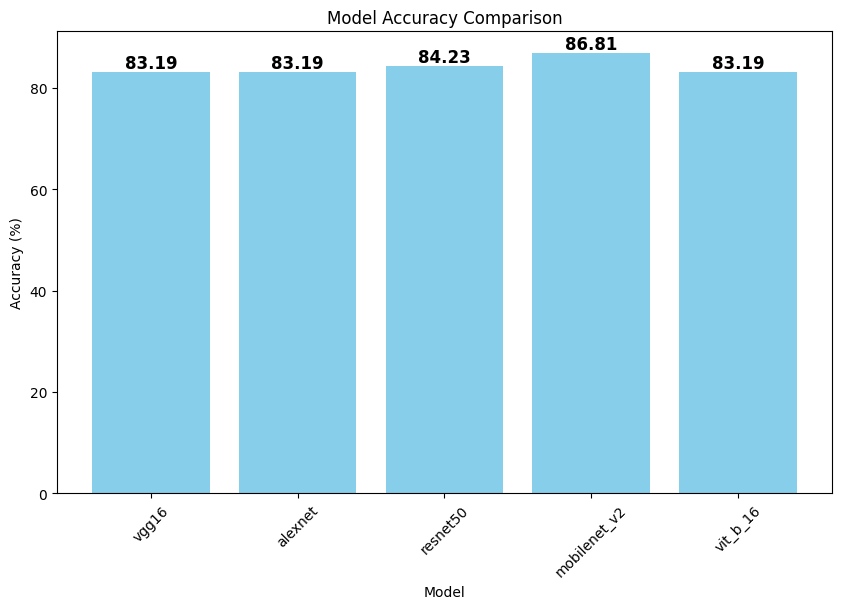

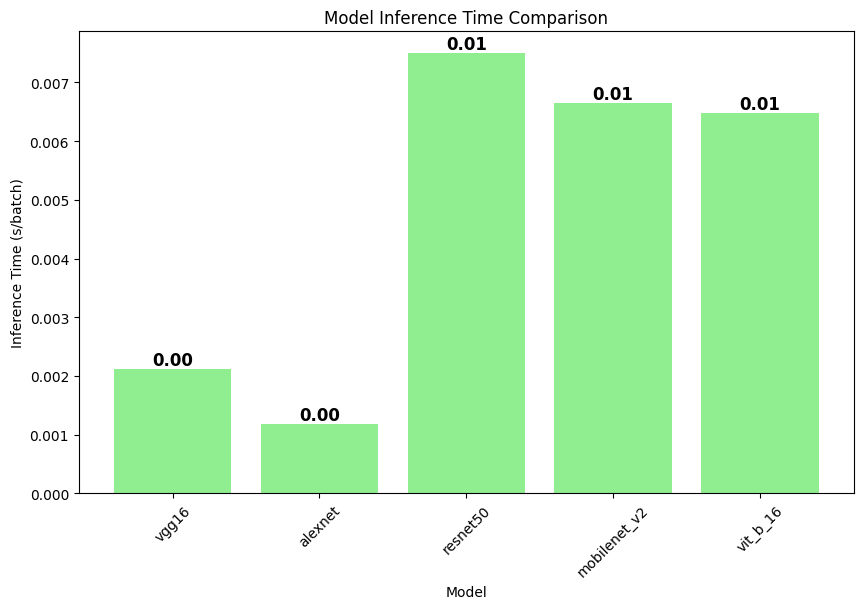

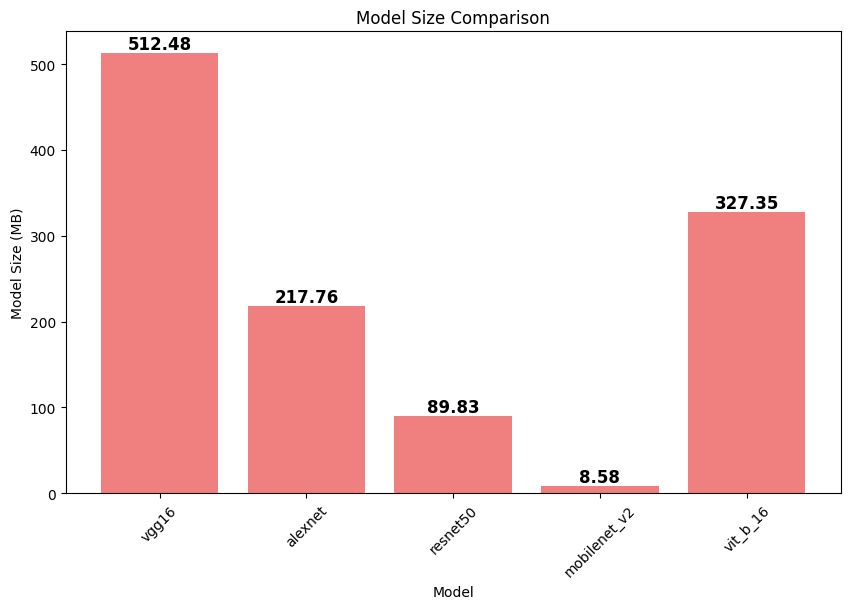

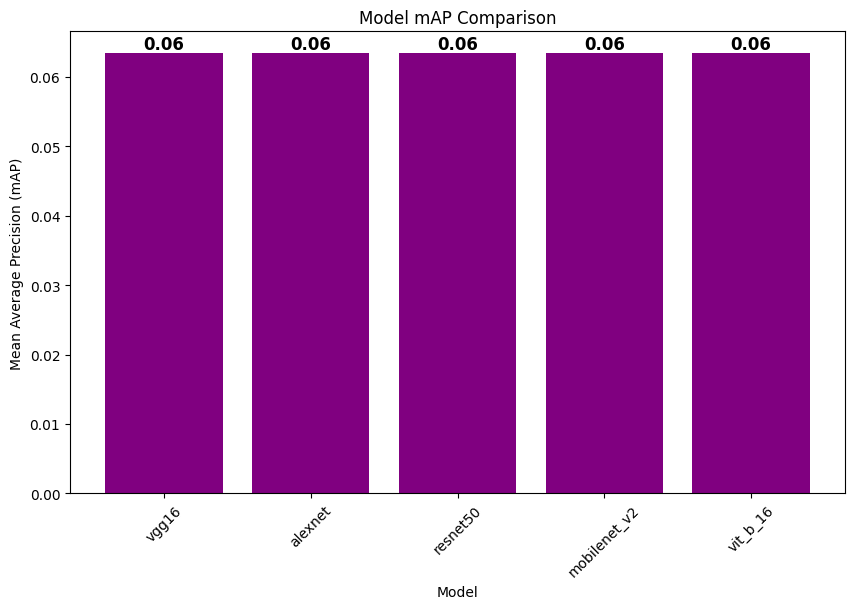

In [ ]:
import matplotlib.pyplot as plt

# Extract the metrics for plotting from previous_results
model_names = list(previous_results.keys())
accuracies = [result[0] for result in previous_results.values()]
inference_times = [result[1] for result in previous_results.values()]
model_sizes = [result[2] for result in previous_results.values()]
mAPs = [result[3] for result in previous_results.values()]

def plot_bar_chart(x_labels, values, color, xlabel, ylabel, title):
    plt.figure(figsize=(10, 6))
    bars = plt.bar(x_labels, values, color=color)

    # Add data labels on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval, f"{yval:.2f}", ha='center', va='bottom', fontsize=12, fontweight='bold')

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.xticks(rotation=45)  # Rotate labels for better readability
    plt.show()

# Plot Accuracy
plot_bar_chart(model_names, accuracies, 'skyblue', 'Model', 'Accuracy (%)', 'Model Accuracy Comparison')

# Plot Inference Time
plot_bar_chart(model_names, inference_times, 'lightgreen', 'Model', 'Inference Time (s/batch)', 'Model Inference Time Comparison')

# Plot Model Size
plot_bar_chart(model_names, model_sizes, 'lightcoral', 'Model', 'Model Size (MB)', 'Model Size Comparison')

# Plot mAP
plot_bar_chart(model_names, mAPs, 'purple', 'Model', 'Mean Average Precision (mAP)', 'Model mAP Comparison')
